# 第12章 多層人工ニューラルネットワークを一から実装する

In [1]:
import sagemaker

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/sagemaker-user/.config/sagemaker/config.yaml


In [2]:
sess = sagemaker.Session()

In [3]:
sess.default_bucket()

'sagemaker-ap-northeast-1-202533513976'

## 12.1 人工ニューラルネットワークによる複雑な関数のモデル化

### 12.1.1 単層ニューラルネットワークのまとめ

### 12.1.2 多層ニューラルネットワークアーキテクチャ

隠れ層が1つ以上存在するネットワークを**ディープ人工ニューラルネットワーク**と呼ぶ

### 12.1.3 フォワードプロパゲーションによるニューラルネットワークの活性化

多層パーセプトロンの学習を3つの単純な手順にまとめる<br>
1. 入力層を出発点として、訓練データのパターンをネットワーク経由で順方向に伝播させ、出力を生成する。
2. ネットワークの出力に基づき、後ほど説明するコスト関数を使って誤差を計算する。この誤差を最小化することが目的となる。
3. 誤差を逆方向に伝播させることで、ネットワーク内の各重みに対する偏導関数を求め、モデルを更新する。

勾配ベースの手法を使ってニュートロンを結合する際の重みを学習するには、活性化関数が微分可能でなければならない。<br>
多層パーセプトロンモデルで画像分析といった複雑な問題を解くには、第3章の**ロジスティック回帰**で使った**シグモイド関数**など、非線形の活性化関数が必要である。

## 12.2 手書きの数字を分類する

### 12.2.1 MNISTデータセットの取得と準備

**MNIST**データセットの手書きの数字を分類するため、多層ニューラルネットワークの実装と訓練を行う。

【後で行うこと】<br>
- S3バケットにMNISTデータセットをアップロードする（練習のためCLIを使う）→ 済
  - 訓練データセットの画像
  - 訓練データセットのラベル
  - テストデータセットの画像
  - テストデータセットのラベル

In [4]:
import sagemaker


bucket = sagemaker.Session().default_bucket()
prefix = "mnist"

# Define IAM role
import boto3
import re
from sagemaker import get_execution_role

role = get_execution_role()

In [5]:
import struct
import numpy as np
import boto3
import io
import gzip
import pickle
from pathlib import Path

S3からのダウンロードを目指す

AWSが用意しているS3バケットからダウンロードできたが、書籍に準拠した形で取り出せないか確認する！

画像をNumPyの配列に読み込み、多層パーセプトロン実装の訓練とテストに使う。そこでヘルパー関数を定義する。

In [6]:
def load_mnist(source_bucket_name, path, kind="train"):
    """MNISTデータをpathからロード"""
    s3 = boto3.resource("s3")
    bucket_minst = s3.Bucket(source_bucket_name)
    # 引数に指定したパスを結合
    labels_path = Path(path) / f"{kind}-labels-idx1-ubyte.gz"
    images_path = Path(path) / f"{kind}-images-idx3-ubyte.gz"
    # ファイルを読み込む：引数にファイル、モードを指定（rbは読み込みのバイナリモード）
    with io.BytesIO() as f:
        bucket_minst.download_fileobj(str(labels_path), f)
        f.seek(0)
        with gzip.open(f, mode='rb') as lbpath:
            # バイナリを文字列に変換：unpack関数の引数にフォーマット、8バイト分の
            # バイナリデータを指定してマジックナンバー、アイテムの個数を読み込む
            magic, n = struct.unpack(">II", lbpath.read(8))
            # ファイルからラベルを読み込み配列を構築：fromfile関数の引数に
            # ファイル、配列のデータ形式を指定
            labels = np.frombuffer(lbpath.read(), dtype=np.uint8)
    with io.BytesIO() as f:
        bucket_minst.download_fileobj(str(images_path), f)
        f.seek(0)
        with gzip.open(f, mode='rb') as imgpath:
            magic, num, rows, cols = struct.unpack(">IIII", imgpath.read(16))
            # 画像ピクセル情報の配列のサイズを変更（行数：ラベルのサイズ、列数：特徴量の個数）
            images = np.frombuffer(imgpath.read(), dtype=np.uint8).reshape(len(labels), 784)
            images = ((images / 255.) - 0.5) * 2

    return images, labels

In [7]:
X_train, y_train = load_mnist(bucket, prefix, kind="train")
print("Rows: %d, columns: %d" % (X_train.shape[0], X_train.shape[1]))

X_test, y_test = load_mnist(bucket, prefix, kind="t10k")
print("Rows: %d, columns: %d" % (X_test.shape[0], X_test.shape[1]))

Rows: 60000, columns: 784
Rows: 10000, columns: 784


0から9の数字を可視化しよう

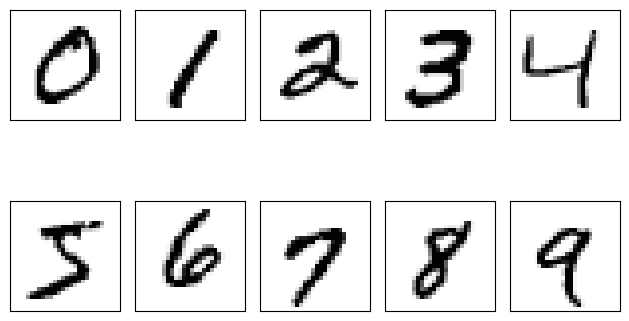

In [8]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(nrows=2, ncols=5, sharex=True, sharey=True)
ax = ax.flatten()

for i in range(10):
    img = X_train[y_train == i][0].reshape(28, 28)
    ax[i].imshow(img, cmap="Greys")

ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
plt.show()

同じ数字の例をいくつか描画して、それらの筆跡の違いを実際に確かめてみよう。

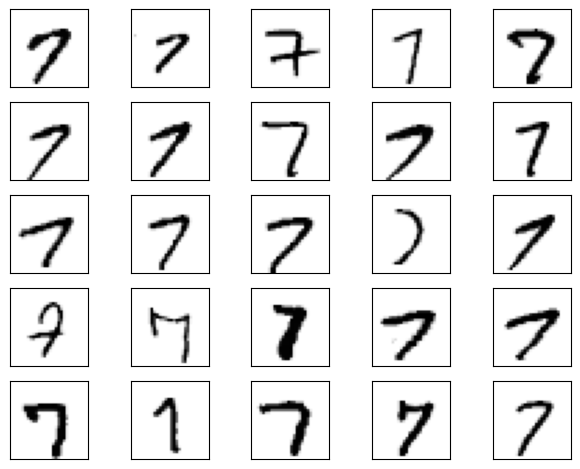

In [9]:
fig, ax = plt.subplots(nrows=5, ncols=5, sharex=True, sharey=True)
ax = ax.flatten()
for i in range(25):
    img = X_train[y_train == 7][i].reshape(28, 28)
    ax[i].imshow(img, cmap="Greys")
ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
plt.show()

スケーリング済みの画像は新しいPythonセッションにすばやく読み込めるフォーマットで保存しておくとよい。Numpyのsavez関数

In [45]:
with io.BytesIO() as f:
    np.savez_compressed(f, X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test)
    f.seek(0)
    # S3バケットに保存する
    s3 = boto3.resource("s3")
    bucket_minst = s3.Bucket(bucket)
    # 引数に指定したパスを結合
    savez_path = Path("mnist") / "mnist_scaled.npz"
    bucket_minst.upload_fileobj(f, str(savez_path))

S3に保存したファイルをダウンロードする。

In [6]:
import tempfile

In [7]:
with tempfile.NamedTemporaryFile(mode='w+b') as fp:
    s3 = boto3.resource("s3")
    bucket_minst = s3.Bucket(bucket)
    savez_path = Path("mnist") / "mnist_scaled.npz"

    bucket_minst.download_fileobj(str(savez_path), fp)

    with open(fp.name, mode='rb') as f:

        f.seek(0)
        f.read()

        mnist = np.load(fp.name)

In [8]:
mnist.files

['X_train', 'y_train', 'X_test', 'y_test']

In [9]:
X_train, y_train, X_test, y_test = [mnist[f] for f in mnist.files]

### 12.2.2 多層パーセプトロンを実装する

In [29]:
import sys

class NeuralNetMLP(object):
    """フィードフォワードニューラルネットワーク/多層パーセプトロン分類器

    パラメータ
    ------------
    n_hidden : int (デフォルト: 30)
        隠れユニットの個数
    l2 : float (デフォルト: 0.)
        L2正則化のλパラメータ
        l2=0の場合は正則化なし (default)
    epochs : int (デフォルト: 100)
        訓練の回数
    eta : float (デフォルト: 0.001)
        学習率
    shuffle : bool (デフォルト: True)
        Trueの場合、循環を避けるためにエポックごとに訓練データをシャッフル
    minibatch_size : int (デフォルト: 1)
        ミニバッチあたりの訓練データの個数
    seed : int (デフォルト: None)
        重みとシャッフルを初期化するための乱数シード

    属性
    ------------
    eval_ : dict
        訓練のエポックごとに、コスト、訓練の正解率、検証の正解率を収集するディクショナリ
    """

    def __init__(self, n_hidden=30, l2=0., epochs=100, eta=0.001,
                shuffle=True, minibatch_size=1, seed=None):
        """NeuralNetMLPの初期化"""

        self.random = np.random.RandomState(seed)
        self.n_hidden = n_hidden
        self.l2 = l2
        self.epochs = epochs
        self.eta = eta
        self.shuffle = shuffle
        self.minibatch_size = minibatch_size

    def _onehot(self, y, n_classes):
        """ラベルをone-hot表現にエンコード

        パラメータ
        ------------
        y : array, shape = [n_examples]
            目的変数の値

        戻り値
        ------------
        onehot : array, shape = (n_examples, n_labels)
        """

        onehot = np.zeros((n_classes, y.shape[0]))
        for idx, val in enumerate(y.astype(int)):
            onehot[val, idx] = 1.

        return onehot.T

    def _sigmoid(self, z):
        """ロジスティック関数（シグモイド）を計算"""
        return 1. / (1. + np.exp(-np.clip(z, -250, 250)))

    def _forward(self, X):
        """フォワードプロパゲーションのステップを計算"""

        # ステップ1: 隠れ層の総入力
        # [n_examples, n_features] dot [n_features, n_hidden]
        # -> [n_examples, n_hidden]
        z_h = np.dot(X, self.w_h) + self.b_h

        # ステップ2: 隠れ層の活性化関数
        a_h = self._sigmoid(z_h)

        # ステップ3: 出力層の総入力
        # [n_examples, n_hidden] dot [n_hidden, n_classlabels]
        # -> [n_examples, n_classlabels]
        z_out = np.dot(a_h, self.w_out) + self.b_out

        # ステップ4: 出力層の活性化関数
        a_out = self._sigmoid(z_out)

        return z_h, a_h, z_out, a_out

    def _compute_cost(self, y_enc, output):
        """コスト関数を計算

        パラメータ
        ------------
        y_enc : array, shape = (n_examples, n_labels)
            one-hot表現にエンコードされたクラスレベル
        output : array, shape = [n_examples, n_output_units]
            出力層の活性化関数（フォワードプロパゲーション）

        戻り値
        ------------
        cost : float
            正則化されたコスト
        """

        L2_term = (self.l2 * (np.sum(self.w_h ** 2.) +
                             np.sum(self.w_out ** 2.)))
        term1 = -y_enc * (np.log(output))
        term2 = (1. - y_enc) * np.log(1. - output)
        cost = np.sum(term1 - term2) + L2_term

        return cost

    def predict(self, X):
        """クラスレベルを予測

        パラメータ
        ------------
        X : array, shape = [n_examples, n_features]
            元の特徴量が設定された入力層

        戻り値
        ------------
        y_pred : array, shape = [n_examples]
            予測されたクラスレベル
        """

        z_h, a_h, z_out, a_out = self._forward(X)
        y_pred = np.argmax(z_out, axis=1)

        return y_pred

    def fit(self, X_train, y_train, X_valid, y_valid):
        """訓練データから重みを学習

        パラメータ
        ------------
        X_train : array, shape = [n_examples, n_features]
            元の特徴量が設定された入力層
        y_train : array, shape = [n_examples]
            目的変数（クラスレベル）
        X_valid : array, shape = [n_examples, n_features]
            訓練時の検証に使うサンプル特徴量
        y_valid : array, shape = [n_examples]
            訓練時の検証に使うサンプルラベル

        戻り値
        ------------
        self

        """

        # クラスラベルの個数
        n_output = np.unique(y_train).shape[0]
        n_features = X_train.shape[1]

        ##############
        # 重みの初期化
        ##############

        # 入力層 -> 隠れ層の重み
        self.b_h = np.zeros(self.n_hidden)
        self.w_h = self.random.normal(loc=0.0, scale=0.1,
                                     size=(n_features, self.n_hidden))

        # 隠れ層 -> 出力層の重み
        self.b_out = np.zeros(n_output)
        self.w_out = self.random.normal(loc=0.0, scale=0.1,
                                       size=(self.n_hidden, n_output))

        # 書式設定
        epoch_strlen = len(str(self.epochs))
        self.eval_ = {"cost": [], "train_acc": [], "valid_acc": []}

        y_train_enc = self._onehot(y_train, n_output)

        # エポック数だけ訓練を繰り返す
        for i in range(self.epochs):

            # ミニバッチの反復処理（イテレーション）
            indices = np.arange(X_train.shape[0])

            if self.shuffle:
                self.random.shuffle(indices)

            for start_idx in range(0, indices.shape[0] - self.minibatch_size + 1,
                                  self.minibatch_size):
                batch_idx = indices[start_idx:start_idx + self.minibatch_size]

                # フォワードプロパゲーション
                z_h, a_h, z_out, a_out = self._forward(X_train[batch_idx])

                #########################
                # バックプロパゲーション
                #########################

                # [n_examples, n_classlabels]
                delta_out = a_out - y_train_enc[batch_idx]

                # [n_examples, n_hidden]
                sigmoid_derivative_h = a_h * (1. - a_h)

                # [n_examples, n_classlabels] dot [n_classlabels, n_hidden]
                # -> [n_examples, n_hidden]
                delta_h = (np.dot(delta_out, self.w_out.T) * sigmoid_derivative_h)

                # [n_features, n_examples] dot [n_examples, n_hidden]
                # -> [n_features, n_hidden]
                grad_w_h = np.dot(X_train[batch_idx].T, delta_h)
                grad_b_h = np.sum(delta_h, axis=0)

                # [n_hidden, n_examples] dot [n_examples, n_classlabels]
                # -> [n_hidden, n_classlabels]
                grad_w_out = np.dot(a_h.T, delta_out)
                grad_b_out = np.sum(delta_out, axis=0)

                # 正則化と重みの更新
                delta_w_h = (grad_w_h + self.l2*self.w_h)
                delta_b_h = grad_b_h # バイアスは正則化しない
                self.w_h -= self.eta * delta_w_h
                self.b_h -= self.eta * delta_b_h

                delta_w_out = (grad_w_out * self.l2*self.w_out)
                delta_b_out = grad_b_out # バイアスは正則化しない
                self.w_out -= self.eta * delta_w_out
                self.b_out -= self.eta * delta_b_out

            ########
            # 評価
            ########

            # イテレーションごとに評価を行う
            z_h, a_h, z_out, a_out = self._forward(X_train)
            cost = self._compute_cost(y_enc=y_train_enc, output=a_out)

            y_train_pred = self.predict(X_train)
            y_valid_pred = self.predict(X_valid)
            train_acc = ((np.sum(y_train == y_train_pred)).astype(np.float64) / 
                        X_train.shape[0])
            valid_acc = ((np.sum(y_valid == y_valid_pred)).astype(np.float64) /
                        X_valid.shape[0])

            sys.stderr.write("\r%0*d/%d | Cost: %.2f "
                            "| Train/Valid Acc.: %.2f%%/%.2f%% " %
                            (epoch_strlen, i+1, self.epochs, cost,
                            train_acc*100, valid_acc*100))
            sys.stderr.flush()

            self.eval_["cost"].append(cost)
            self.eval_["train_acc"].append(train_acc)
            self.eval_["valid_acc"].append(valid_acc)

        return self

In [30]:
nn = NeuralNetMLP(n_hidden=100,
                 l2=0.01,
                 epochs=200,
                 eta=0.0005,
                 minibatch_size=100,
                 shuffle=True,
                 seed=1)

In [31]:
nn.fit(X_train=X_train[:55000], y_train=y_train[:55000], X_valid=X_train[55000:], y_valid=y_train[55000:])

200/200 | Cost: 47489.46 | Train/Valid Acc.: 91.90%/93.72%  

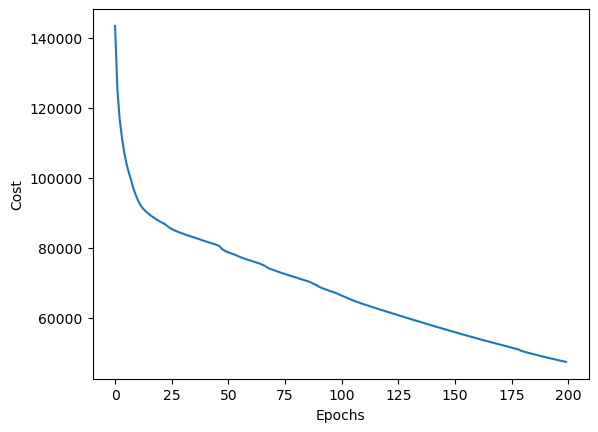

In [33]:
import matplotlib.pyplot as plt
plt.plot(range(nn.epochs), nn.eval_["cost"])
plt.ylabel("Cost")
plt.xlabel("Epochs")
plt.show()

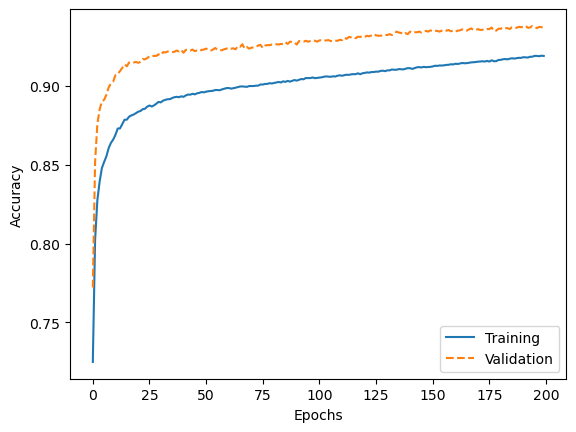

In [34]:
plt.plot(range(nn.epochs), nn.eval_["train_acc"], label="Training")
plt.plot(range(nn.epochs), nn.eval_["valid_acc"], label="Validation", linestyle="--")
plt.ylabel("Accuracy")
plt.xlabel("Epochs")
plt.legend(loc="lower right")
plt.show()

In [35]:
y_test_pred = nn.predict(X_test)
acc = (np.sum(y_test == y_test_pred).astype(np.float64) / X_test.shape[0])
print("Test accuracy: %.2f%%" % (acc * 100))

Test accuracy: 92.24%


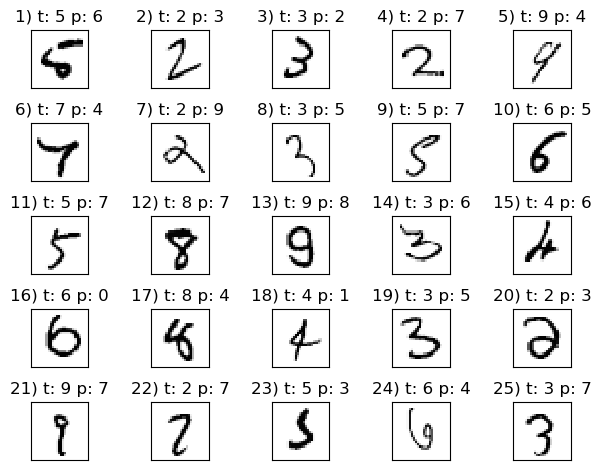

In [36]:
miscl_img = X_test[y_test != y_test_pred][:25]
correct_lab = y_test[y_test != y_test_pred][:25]
miscl_lab = y_test_pred[y_test != y_test_pred][:25]
fig, ax = plt.subplots(nrows=5, ncols=5, sharex=True, sharey=True)
ax = ax.flatten()
for i in range(25):
    img = miscl_img[i].reshape(28, 28)
    ax[i].imshow(img, cmap="Greys", interpolation="nearest")
    ax[i].set_title("%d) t: %d p: %d" % (i+1, correct_lab[i], miscl_lab[i]))

ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
plt.show()

## 12.3 人工ニューラルネットワークの訓練

### 12.3.1 ロジスティック関数を計算する

ロジスティック関数
$$
J(w)=-\sum^{n}_{i=1} \log(a^{[i]})+(1-y^{[i]})\log(1-a^{[i]})
$$

ここで、$a^{[i]}$はデータセットの$i$番目のデータ点に対するシグモイド関数の出力結果である。<br>
$$
a^{[i]} = \phi{(z^{[i]})}
$$
ここで、上付き文字$[i]$は（層ではなく）訓練データのインデックスを表す。

過学習の度合いを下げることができる**正則化**の項を追加する。

$$
\mathrm{L2} = \lambda ||w||^{2}_{2} = \lambda \sum^{m}_{j=1} w^{2}_{j}
$$

L2正則化の項をロジスティック関数に追加すると、次の式が得られる。

$$
J(w)=-\Biggl[\sum^{n}_{i=1} y^{[i]} \log(a^{[i]})+(1-y^{[i]})\log(1-a^{[i]})\Biggr] + \frac{\lambda}{2} ||w||^{2}_{2}
$$

ネットワーク内のすべての活性化ユニット$t$に対してロジスティック関数を一般化する必要がある。<br>
コスト関数は次のようになる

$$
J(W)=-\Biggl[\sum^{n}_{i=1} \sum^{t}_{j=1} y^{[i]} \log(a^{[i]})+(1-y^{[i]})\log(1-a^{[i]})\Biggr] + \frac{\lambda}{2} \sum^{L-1}_{l=1} \sum^{u_{l}}_{i=1} \sum^{u_{l+1}}_{j=1} (w^{(l)}_{j,i})^{2}
$$

ここで、$u_{l}$は層$l$のユニットの個数を表す。$L$は層の数。

コスト関数$J(W)$を最小化することが目的である。<br>
ネットワークのすべての層の重みごとに、行列$W$の偏微分係数を計算する必要がある。
$$
\frac{\partial}{\partial w^{(l)}_{j,i}} J(W)
$$

### 12.3.2 バックプロパゲーションに対する理解を深める

多層ニューラルネットワークにおいて複雑なコスト関数の偏導関数を求める際に、その計算を非常に効率よく行う手法として考えることができる。

偏導関数を使って、多層人工ニューラルネットワークをパラメータ化するための重み係数を学習することにある。

連鎖律
$$
\frac{d}{dx} [f(g(x))] = \frac{df}{dg} \cdot \frac{dg}{dx}
$$

任意の長さの関数を合成するための連鎖律も利用できる
$$
\frac{dF}{dx} = \frac{d}{dx} F(x) = \frac{d}{dx} f(g(h(u(v(x))))) = \frac{df}{dg} \cdot \frac{dg}{dh} \cdot \frac{dh}{du} \cdot \frac{du}{dv} \cdot \frac{dv}{dx}
$$

そうした問題を非常に効率よく解くための一連の手法が**自動微分**と呼ばれる。

**自動微分**には、**フォワード**と**リバース**の2つのモードがある。<br>
連鎖律をフォワードモードで適用すると計算コストがかなり高くなる可能性がある。<br>
リバースモードは右から左へ処理する。行列にベクトルを掛け、結果として新たなベクトルに次の行列を掛ける。<br>
バックプロパゲーションがニューラルネットワークの訓練において最も人気の高いアルゴリズムの1つになっているのはそのため。

### 12.3.3 バックプロパゲーションによるニューラルネットワークの訓練

フォワードプロパゲーションの適用について

隠れ層の総入力
$$
Z^{(h)} = A^{(in)} W^{(h)}
$$

隠れ層の活性化関数
$$
A^{(h)} = \phi{(Z^{(h)})}
$$

出力層の総入力
$$
Z^{(out)} = A^{(h)} W^{(out)}
$$

出力層の活性化関数
$$
A^{(out)} = \phi{(Z^{(out)})}
$$

ネットワーク内の結合を通じて入力特徴量を順方向に伝播させただけ

バックプロパゲーションでは、誤差を右から左へ伝播させる。

出力層の誤差ベクトルを計算する
$$
\delta^{(out)} = a^{(out)} - y
$$

$y$は正しいクラスラベルからなるベクトルである

次に隠れ層の誤差項を計算する。
$$
\delta^{(h)} = \delta^{(out)} (W^{(out)})^{T} \odot \frac{\partial \phi(z^{(h)})}{\partial z^{(h)}}
$$

$\odot$は要素ごとの乗算を意味する。

以下のように定義される。

$$
\frac{\partial \phi(z^{(h)})}{\partial z^{(h)}} = (a^{(h)} \odot (1 - a^{(h)}))
$$

隠れ層の誤差行列$\delta^{(h)}$
$$
\delta^{(h)} = \delta^{(out)} (W^{(out)})^{T} \odot (a^{(h)} \odot (1 - a^{(h)}))
$$

コスト関数の偏微分係数
$$
\frac{\partial}{\partial w^{(out)}_{i, j}} J(W) = a^{(h)}_{j} \delta^{(out)}_{i}
$$
$$
\frac{\partial}{\partial w^{(h)}_{i, j}} J(W) = a^{(in)}_{j} \delta^{(h)}_{i}
$$

$$
\Delta^{(h)} = (A^{(in)})^{T} \delta^{(h)}
$$
$$
\Delta^{(out)} = (A^{(h)})^{T} \delta^{(out)}
$$

$$
\Delta^{(l)} := \Delta^{(l)} + \lambda^{(l)} W^{(l)}
$$

勾配を計算した後は、勾配に対して逆方向に進むことで重みを更新できる。
$$
W^{(l)} := W^{(l)} - \eta \Delta^{(l)}
$$